# Food segmentation with a U-Net-like architecture

**Description:** Food segmentation model trained from scratch on coco dataset.

In [2]:
!git clone https://github.com/gmurro/FoodRecognition.git

Cloning into 'FoodRecognition'...
remote: Enumerating objects: 76312, done.
remote: Counting objects: 100% (50808/50808), done.
remote: Compressing objects: 100% (27368/27368), done.
remote: Total 76312 (delta 23486), reused 50759 (delta 23439), pack-reused 25504
Receiving objects: 100% (76312/76312), 1.31 GiB | 23.75 MiB/s, done.
Resolving deltas: 100% (23522/23522), done.
Checking out files: 100% (52101/52101), done.


In [3]:
%cd /content/FoodRecognition/src

/content/FoodRecognition/src


Auxiliary function to plot images

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_im(img_path, img=None):
  """
  Auxiliary function to plot images. 

  Parameters
  ----------
  img_path : str
      The file location from which read the image. It is ignored if you pass img.
  img : np.array, optional
      If you have a np.array object in a form of image, you can pass it direcly.
  """

  fig = plt.figsize=(10,)

  # read image from the defined path if img it is available
  if img is None:
    img = mpimg.imread(img_path)

  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [95]:
def show_multiple_im(input_img_paths, target_img_paths, predictions=None, figsize=(10,10)):
  """
  Auxiliary function to plot a batch of images. 

  Parameters
  ----------
  input_img_paths : str
      The file locations from which read the input images.
  target_img_paths : str
      The file locations from which read the masks.
  predictions : np.array, optional
      Batch of predictions.
  figsize :  array
      Size of the figure to plot.
  """

  n_images = len(input_img_paths)

  # plot 3 or 2 columns if predictions is available or not
  ncols = 2 if predictions is None else 3

  fig, axes = plt.subplots(figsize=figsize, nrows=n_images, ncols=ncols)

  for i, (input_img_path, target_img_path) in enumerate(zip(input_img_paths, target_img_paths)):
    img = mpimg.imread(input_img_path)
    ax = axes[i,0] if n_images > 1 else axes[0]
    ax.imshow(img)
    ax.axis('off')

    mask = mpimg.imread(target_img_path)
    ax = axes[i,1] if n_images > 1 else axes[1]
    ax.imshow(mask)
    ax.axis('off')

    if predictions is not None:
      ax = axes[i,2] if n_images > 1 else axes[2]
      ax.imshow(predictions[i])
      ax.axis('off')

  # set column title
  col_titles = ['Input', 'Target', 'Predictions']
  if n_images > 1:
    for ax, col in zip(axes[0], col_titles):
      ax.set_title(col)
  else:
    for ax, col in zip(axes, col_titles):
      ax.set_title(col)

  fig.tight_layout()
  plt.show()

## Prepare paths of input images and target segmentation masks

In [5]:
img_size = (160, 160)
num_classes = 2
batch_size = 32

In [6]:
import os

# prepare data for training 

input_train_dir = "../data/train/images/"
masks_train_dir = "../data/train/masks/"

input_train_paths = sorted(
    [
        os.path.join(input_train_dir, fname)
        for fname in os.listdir(input_train_dir)
        if fname.endswith(".jpg")
    ]
)

target_train_paths = sorted(
    [
        os.path.join(masks_train_dir, fname)
        for fname in os.listdir(masks_train_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


for input_path, target_path in zip(input_train_paths[:5], target_train_paths[:5]):
    print(input_path, "|", target_path)

n_train_sample = len(input_train_paths)
print("Number of training samples:", n_train_sample)

../data/train/images/006316.jpg | ../data/train/masks/006316.png
../data/train/images/006331.jpg | ../data/train/masks/006331.png
../data/train/images/006335.jpg | ../data/train/masks/006335.png
../data/train/images/006346.jpg | ../data/train/masks/006346.png
../data/train/images/006354.jpg | ../data/train/masks/006354.png
Number of training samples: 24120


In [7]:
# prepare data for validation 

input_val_dir = "../data/val/images/"
masks_val_dir = "../data/val/masks/"


input_val_paths = sorted(
    [
        os.path.join(input_val_dir, fname)
        for fname in os.listdir(input_val_dir)
        if fname.endswith(".jpg")
    ]
)

target_val_paths = sorted(
    [
        os.path.join(masks_val_dir, fname)
        for fname in os.listdir(masks_val_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


for input_path, target_path in zip(input_val_paths[:5], target_val_paths[:5]):
    print(input_path, "|", target_path)

n_val_sample = len(input_val_paths)
print("Number of validation samples:", n_val_sample)

../data/val/images/006452.jpg | ../data/val/masks/006452.png
../data/val/images/006505.jpg | ../data/val/masks/006505.png
../data/val/images/006536.jpg | ../data/val/masks/006536.png
../data/val/images/006568.jpg | ../data/val/masks/006568.png
../data/val/images/006595.jpg | ../data/val/masks/006595.png
Number of validation samples: 1269


## What does one input image and corresponding segmentation mask look like?

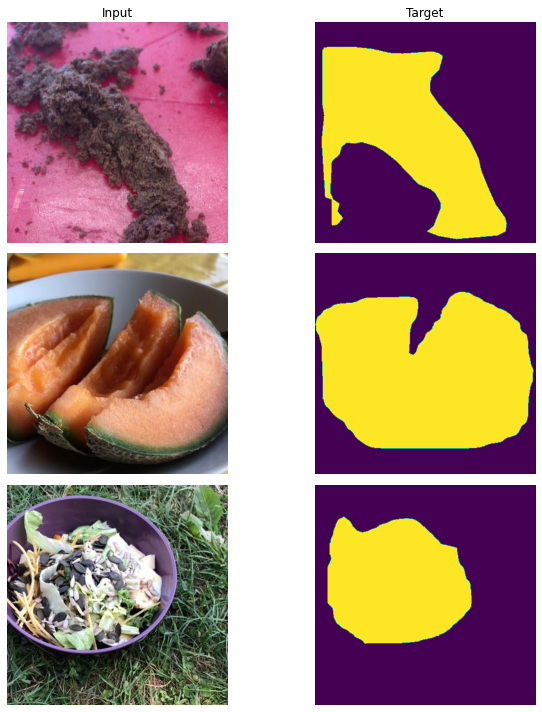

In [98]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import PIL
from PIL import ImageOps
import numpy as np

# Display 3 input images and their mask
n = 3

imgs = input_train_paths[0:n]
masks = target_train_paths[0:n]

# show images
show_multiple_im(imgs, masks)

In [9]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


class FoodRecognition(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
           
        return x, y

Prepare U-Net Xception-style model

In [10]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

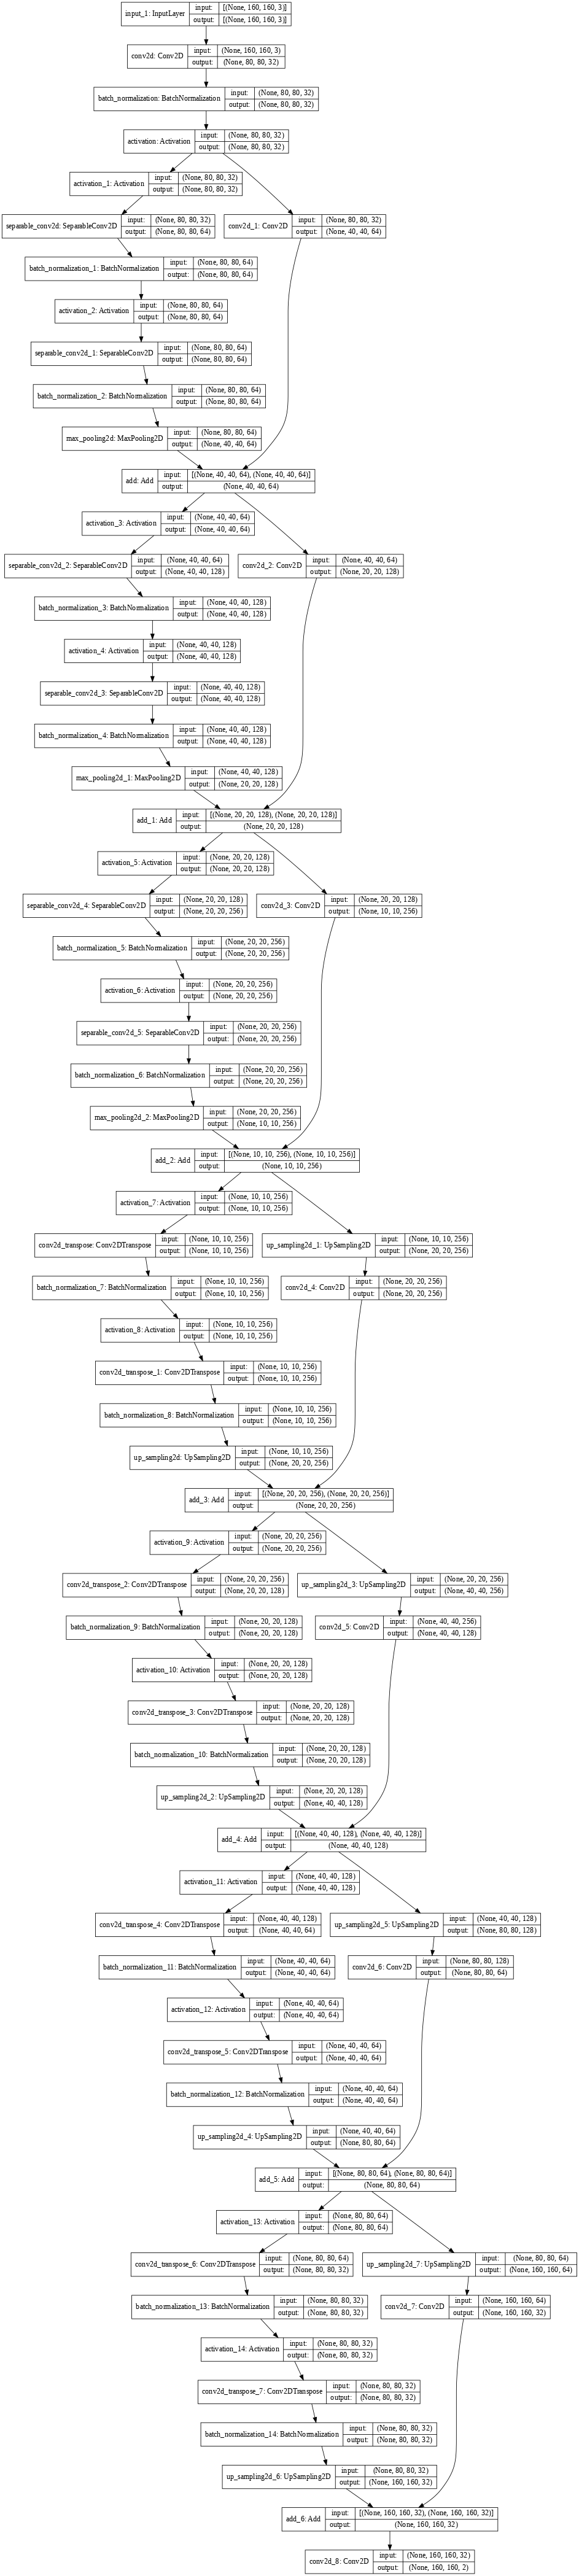

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

In [12]:
# Instantiate data Sequences for training and validation set
train_gen = FoodRecognition(batch_size, img_size, input_train_paths, target_train_paths)
val_gen = FoodRecognition(batch_size, img_size, input_val_paths, target_val_paths)

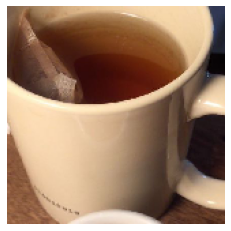

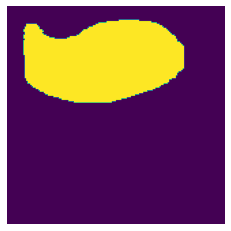

The values in the mask are: [0 1]


In [13]:
# print random image from dataset
import random

i = random.randint(0,batch_size)
img = np.array(val_gen.__getitem__(0)[0][i,:,:,:], dtype = np.uint8)
mask = np.array(val_gen.__getitem__(0)[1][i,:,:,0], dtype = np.uint8)

show_im("", img)
show_im("", mask)

print("The values in the mask are: {}".format(np.unique(val_gen.__getitem__(0)[1][i,:,:,0])))

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [ ]:
from datetime import datetime
cp_file_name = "model/food_segmentation_"+str(datetime.now()).replace(" ","_")+".h5"

callbacks = [
    #Model checkpoint save weights ad other informations
    keras.callbacks.ModelCheckpoint(cp_file_name, save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

In [89]:
# if you have pretrained weights, load them here
model.load_weights('model/food_segmentation.h5')

In [90]:
val_gen = FoodRecognition(batch_size, img_size, input_val_paths, target_val_paths)
val_preds = model.predict(val_gen)

In [91]:
def display_mask(i, size=img_size):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.resize(size)
    display(img)
    print(img.size)

def get_pred_mask(pred):
   mask = np.argmax(pred, axis=-1)
   return mask

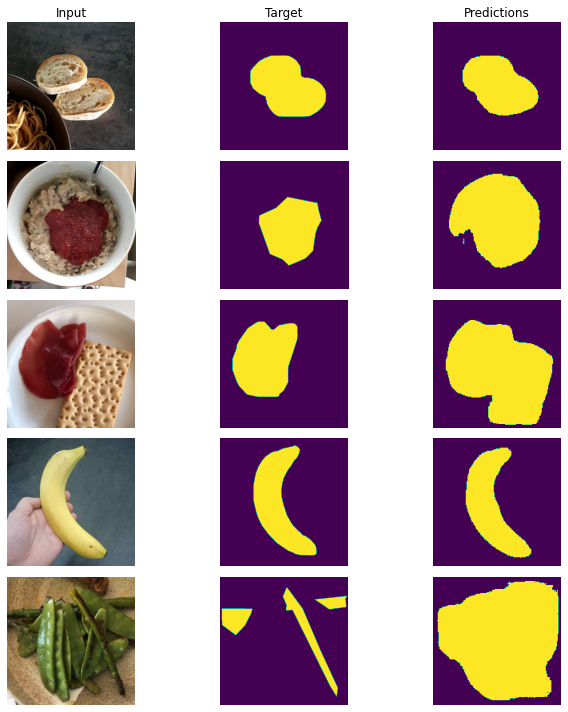

In [99]:
# Display 5 random predictions
n = 5

idx = np.random.choice(range(len(val_preds)), n)

imgs = [input_val_paths[i] for i in idx]
masks = [target_val_paths[i] for i in idx]
predicions = [get_pred_mask(val_preds[i]) for i in idx]

show_multiple_im(imgs, masks, predicions)